In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from MFKSSteadyState import *
from utils import reparameterize
from tqdm import tqdm

In [ ]:
# dear futute Natan, the code for the steady state is still messy and not very robust. Sorry for that. 
# Good news is that the edge cases (when the eq. just starts existing) can be made precise by decreasing tol or increasing lbd_max or both.
# Bad news is that lowering lbd_spl below some values seems simply impossible. 

100%|██████████| 234/234 [09:02<00:00,  2.32s/it]


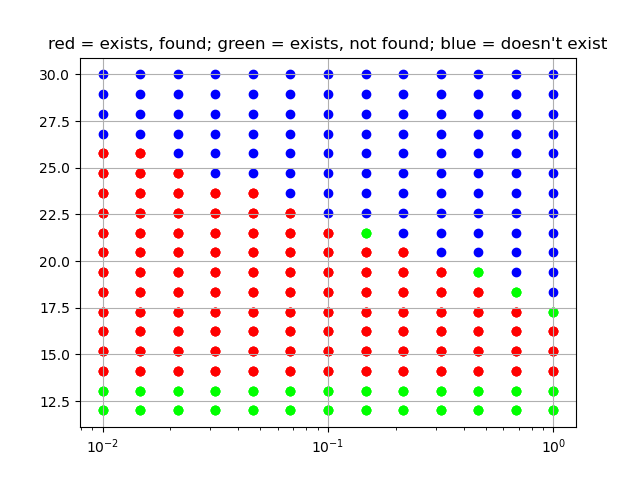

In [28]:
Drho = 0.1
Dc = 1.0
T = 5.0
# epsilon = 1e-0
# r = 1e-4

# lbd_spl = 30.0

n_epsilon = 13
epsilon_range = np.logspace(-2, 0, n_epsilon, endpoint=True)

r = 1e-4

n_lbd_spl = 18
lbd_spl_range = np.linspace(12, 30, n_lbd_spl)

params_list = [(Drho, Dc, T, epsilon, r, lbd_spl) for lbd_spl in lbd_spl_range for epsilon in epsilon_range]
fig, ax = plt.subplots()
for i, params in tqdm(enumerate(params_list), total=len(params_list)):
    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps = reparameterize(Drho, Dc, T, epsilon)

    lbd_max = -1 / k * np.log(eps / k / kappa)
    # print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

    # xmax = lbd_spl + 5.0
    if parameter_control(kappa, k, eps, lbd_spl):
        for tol in [1e-6, 1e-8, 1e-10]:
            try:
                x_ss, P_ss = get_P_ss(np.maximum(lbd_spl+5, lbd_max), kappa, k, eps, lbd_spl, r, tol=tol)
                ax.scatter([epsilon], [lbd_spl], c=[(1,0,0)])
                continue
            except:
                pass
                ax.scatter([epsilon], [lbd_spl], c=[(0,1,0)])
    else:
        ax.scatter([epsilon], [lbd_spl], c=[(0,0,1)])

ax.set_xscale('log')
ax.grid()
plt.title('red = exists, found; green = exists, not found; blue = doesn\'t exist')
plt.show()

In [9]:
# useful line to predict existence
from scipy.optimize import fsolve
eps_range = reparameterize(Drho, Dc, T, epsilon_range)[2]
scale_argument = np.asarray([fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30) for eps in eps_range]).flatten()
# scale_argument2 = - 2 / k * np.log(eps_range / k / kappa)

ax.plot(epsilon_range, scale_argument)
# ax.plot(epsilon_range, scale_argument2/2)

In [26]:
# some tests
Drho = 0.1
Dc = 1.0
T = 5.0
r = 1e-4
epsilon = 1e0
lbd_spl = 12

kappa, k, eps = reparameterize(Drho, Dc, T, epsilon)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

for xadd in [20]:
    for mytol in [1e-10]:
        try:
            x_ss, P_ss = get_P_ss(lbd_spl + xadd, kappa, k, eps, lbd_spl, r, verbose=False, tol=mytol)
            print(get_lbd_inf(np.trapz(P_ss * g(x_ss, kappa, k, eps), x_ss), kappa, k, eps))
            print(f"Succes at {xadd = }, {mytol = }")

        except:
            print(f"Failed at {xadd = }, {mytol = }")

Emerging scales: lbd_spl/2 = 6.00, lbd_max = 11.28, lbd_spl = 12.00
Bracket for g_avg (0.00023960656331216586, 0.003880815815004404)
Trying with 0.0020602111891582847, giving interval lbd_0 = 6.6672322384068785,  lbd_inf = 107.36213617885785
We have lbd_max < lbd_inf, homogeneous approximation will be made. 
Dealing with (8.0, 16.0). Maximum of P here is 508.06481095630033. 
Dealing with (4.0, 8.0). Maximum of P here is 2118235.249206437. 
Dealing with (2.0, 4.0). Maximum of P here is 38.04198378859631. 
Dealing with (1.0, 2.0). Maximum of P here is 4.829230664727765. 
Dealing with (0.5, 1.0). Maximum of P here is 1.7655628617656556. 
Dealing with (0.25, 0.5). Maximum of P here is 1.0693384822088248. 
Dealing with (0.125, 0.25). Maximum of P here is 0.8323947556733375. 
Trying with 0.0002993511195947903, giving interval lbd_0 = 9.465409301760678,  lbd_inf = 15.586371906480379
Dealing with (3.8965929766200946, 7.793185953240189). Maximum of P here is 301.62483747251315. 
Dealing with (1

In [8]:
# approximations of steady state
from scipy.optimize import fsolve

def lbd_0_set_func(x, kappa, k, eps, lbd_spl, r):
    return r / np.log(2) * (x - 0.5 * lbd_spl)**2 - g(x, kappa, k, eps)

def set_lbd_0(kappa, k, eps, lbd_spl, r):
    return fsolve(lbd_0_set_func, x0=0.5*lbd_spl + 1e-8, args=(kappa, k, eps, lbd_spl, r))

def get_P_ss_approx(x_array, lbd_0, kappa, k, eps, lbd_spl, r):
    g_avg = kappa * np.exp(-k * lbd_0) + eps * lbd_0
    vM_array = g_avg - (kappa * np.exp(-k * x_array) + eps * x_array)
    res = np.ones_like(x_array)
    mask_mid = (x_array >= lbd_spl/2) * (x_array <= lbd_spl)
    x_array_mid = x_array[mask_mid]
    res[mask_mid] = (np.exp(-r * (x_array_mid - 0.5*lbd_spl)**2 / g_avg) - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg)) / (1 - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg))
    mask_hi = x_array >= lbd_spl
    x_array_hi = x_array[mask_hi]
    res[mask_hi] = (np.exp(-r * 0.5**2 * lbd_spl**2 / g_avg) - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg)) / (1 - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg)) * np.exp(-r * (x_array_hi - lbd_spl)**2 / g_avg / 4)
    # normalize
    res = np.nan_to_num(- res / vM_array)
    return res / np.trapz(res, x_array)

def get_P_ss_approx_auto(x_array, kappa, k, eps, lbd_spl, r):
    lbd_0 = set_lbd_0(kappa, k, eps, lbd_spl, r)
    assert lbd_0 > 0.5*lbd_spl
    assert lbd_0 < lbd_spl
    return get_P_ss_approx(x_array, lbd_0, kappa, k, eps, lbd_spl, r)

def get_g_avg_approx(kappa, k, eps, lbd_spl, r):
    lbd_0 = set_lbd_0(kappa, k, eps, lbd_spl, r)
    assert lbd_0 > 0.5*lbd_spl
    assert lbd_0 < lbd_spl
    return kappa * np.exp(-k * lbd_0) + eps * lbd_0


In [7]:
# approximations of steady state (plot)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
import warnings
from utils import reparameterize
from MFKSSteadyState import get_P_ss 
warnings.filterwarnings('ignore', category=RuntimeWarning)

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-6 # initial
r = 1e-3

dx = 1e-4
lbd_max = 30


# Function to plot
def plot_functions(lbd_max, epsilon, r, lbd_spl, log_y):

    kappa, k, eps = reparameterize(Drho, Dc, T, epsilon)

    x_range, P_range = get_P_ss(lbd_max, kappa, k, eps, lbd_spl, r, dx, tol=1e-8, verbose=False)
    # x_range = np.linspace(0, lbd_max, 1000)
    # P_range_approx = get_P_ss_approx(x_range, lbd_0, kappa, k, eps, lbd_spl, r)
    P_range_approx3 = get_P_ss_approx_auto(x_range, kappa, k, eps, lbd_spl, r)
    
    lbd_max = -1 / k * np.log(eps / k / kappa)
    print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

    plt.figure(figsize=(10, 6))
    plt.plot(x_range, P_range, 'k-', label='Full steady state')
    plt.plot(x_range, P_range_approx3, 'g-', label='steady state approx3')
    
    ylims = plt.ylim()
    # plt.plot(x_range, P_range_approx3, 'r--', label='steady state approx')
    # plt.vlines([lbd_spl], [ylims[0]], [ylims[1]], colors=['k'])
    # plt.vlines([lbd_0_infered], [ylims[0]], [ylims[1]], colors=['r'])
    plt.ylim(*ylims)

    if log_y:
        plt.yscale('log')
    

    plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('Function Value')
    plt.title('Interactive Plot of Functions')
    plt.grid(True)
    plt.show()

# Define sliders and checkboxes
lbd_max_slider = widgets.IntSlider(value=50, min=10, max=100, step=1, continuous_update=False, description='lbd_max')
epsilon_slider = widgets.FloatLogSlider(value=2e-3, base=10, min=-3, max=-1, step=0.01, readout_format='.3e', continuous_update=False, description='epsilon')
r_slider = widgets.FloatLogSlider(value=1e-1, base=10, min=-8, max=-1, step=0.1, readout_format='.2e', continuous_update=False, description='r')
lbd_spl_slider = widgets.FloatSlider(value=30, min=10, max=100, step=0.5, readout_format='.1f', continuous_update=False, description='lbd_spl')
log_y_toggle = widgets.ToggleButton(value=False, description='Log y-axis', button_style='')

# Create interactive plot
interactive_plot = interactive(plot_functions, 
                               lbd_max=lbd_max_slider,
                               epsilon=epsilon_slider,
                               r=r_slider,
                               lbd_spl=lbd_spl_slider,
                               log_y=log_y_toggle)

display(interactive_plot)


interactive(children=(IntSlider(value=50, continuous_update=False, description='lbd_max', min=10), FloatLogSli…